In [41]:
# ----------------------------
# 1) Install (Colab / notebook)
# ----------------------------
!pip install -q git+https://github.com/amazon-science/chronos-forecasting.git
!pip install -q tsdb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [42]:
# ----------------------------
# 2) Imports
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error

from chronos import ChronosPipeline
import torch

In [43]:
# ----------------------------
# 3) Load Superstore -> Daily sales series
# ----------------------------
df_raw = pd.read_csv("Sample - Superstore.csv", encoding="ISO-8859-1")
df_raw["Order Date"] = pd.to_datetime(df_raw["Order Date"], errors="coerce")
df_raw = df_raw.dropna(subset=["Order Date"])

# Daily total sales (Prophet-style ds/y is optional; Chronos needs just a 1D series)
daily_sales = (
    df_raw.groupby("Order Date")["Sales"]
          .sum()
          .asfreq("D")
          .fillna(0.0)
          .rename("y")
)

daily_sales.head(), daily_sales.index.min(), daily_sales.index.max()


(Order Date
 2014-01-03      32.896
 2014-01-04     288.060
 2014-01-05      19.536
 2014-01-06    8814.200
 2014-01-07     174.316
 Freq: D, Name: y, dtype: float64,
 Timestamp('2014-01-03 00:00:00'),
 Timestamp('2017-12-30 00:00:00'))

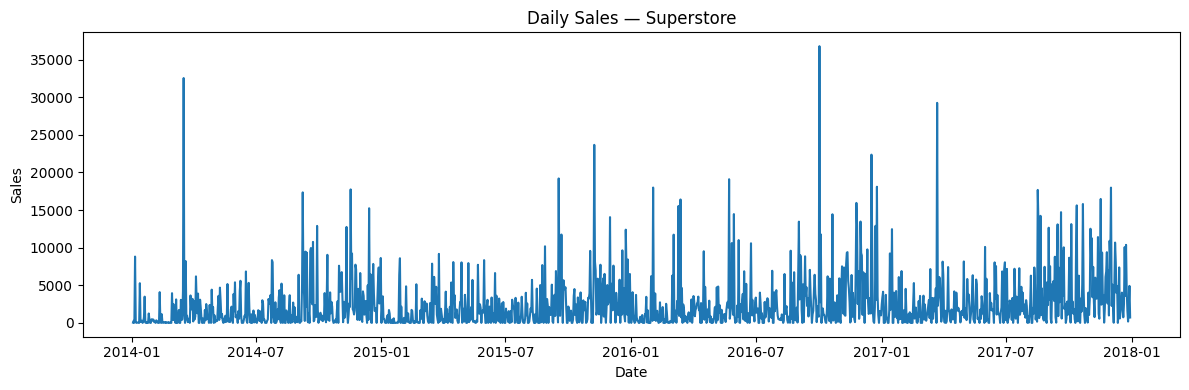

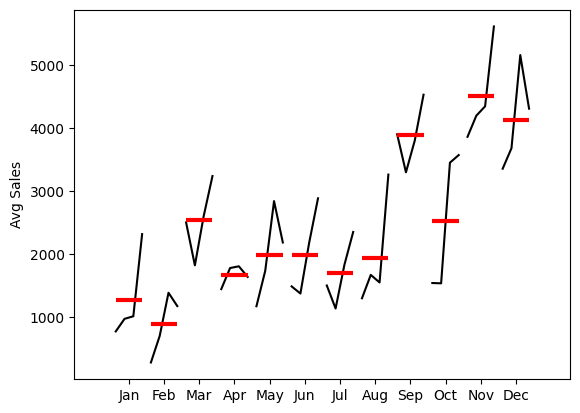

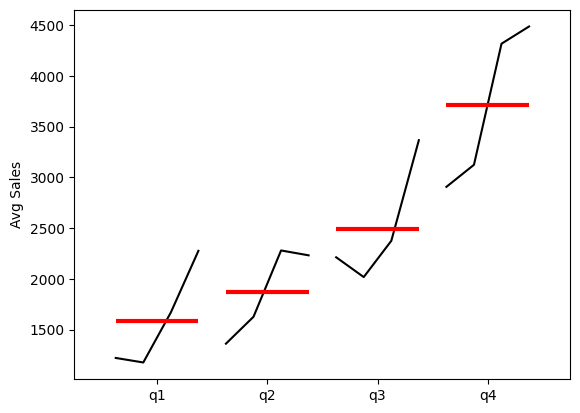

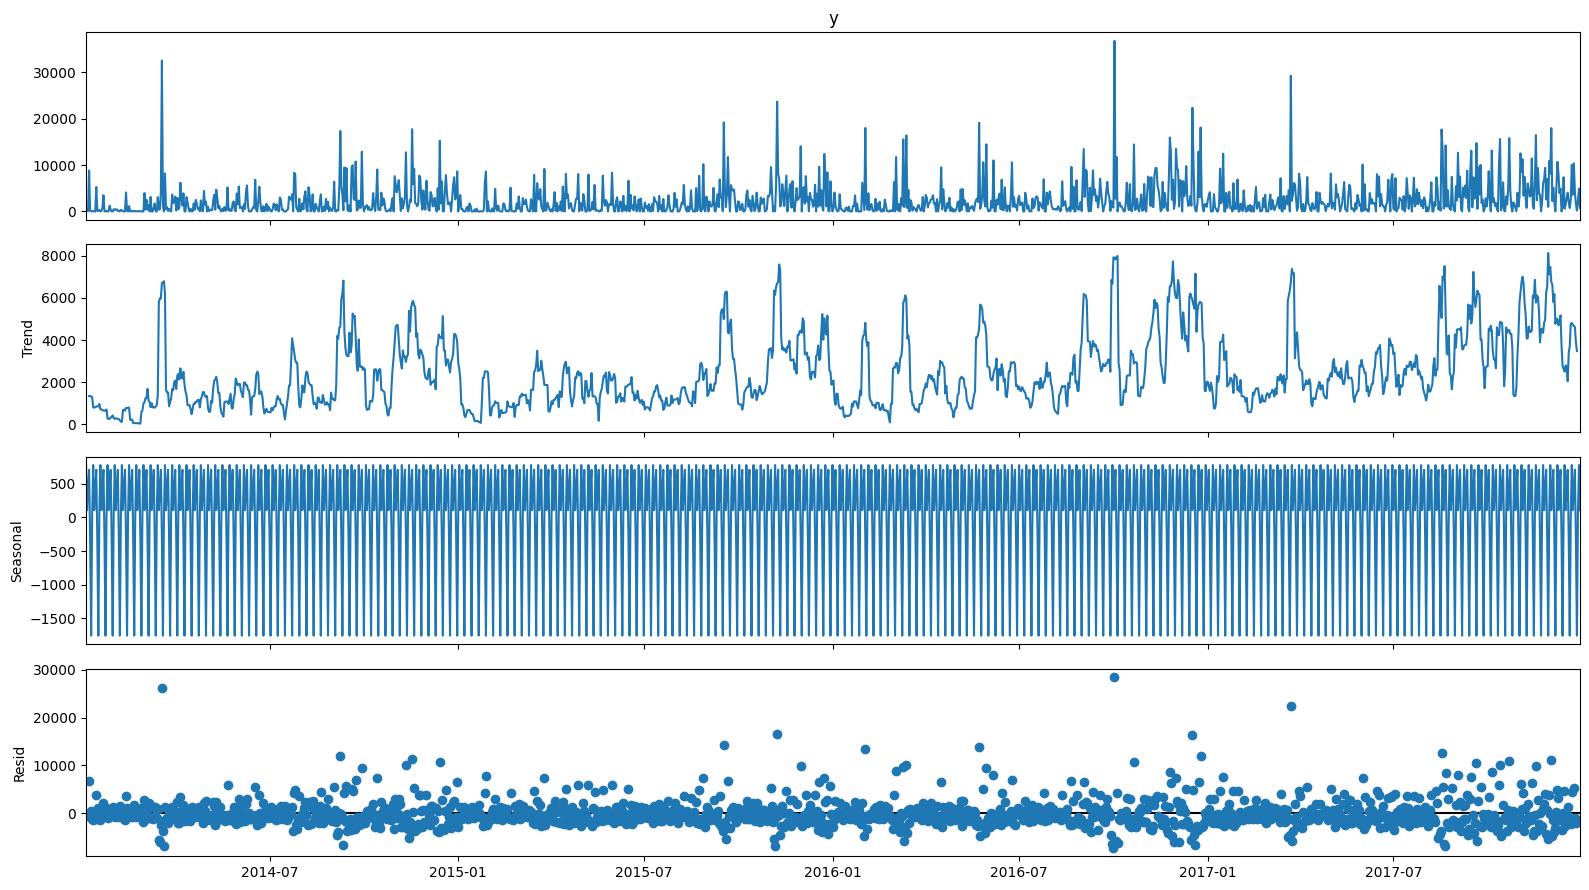

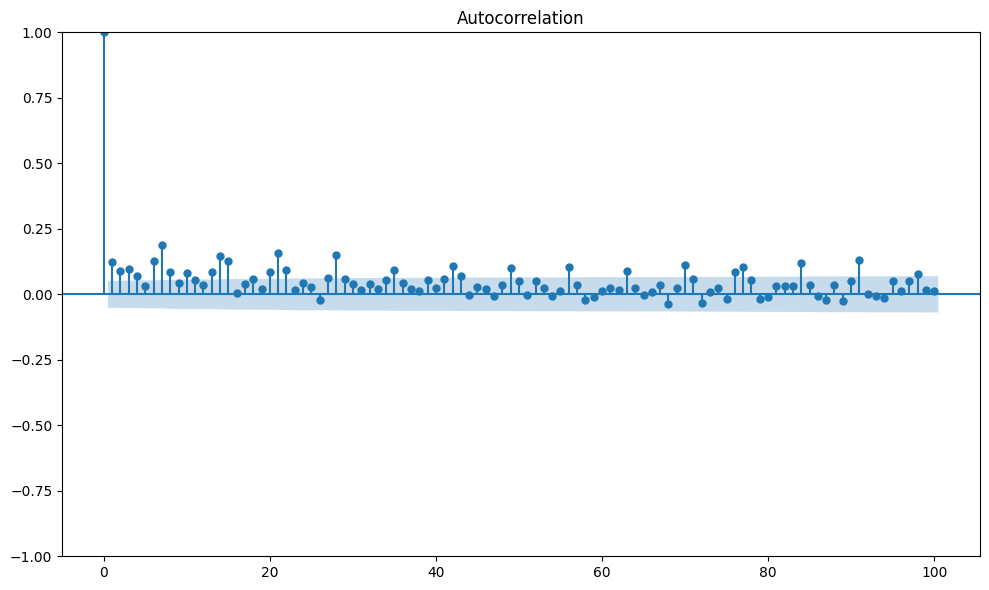

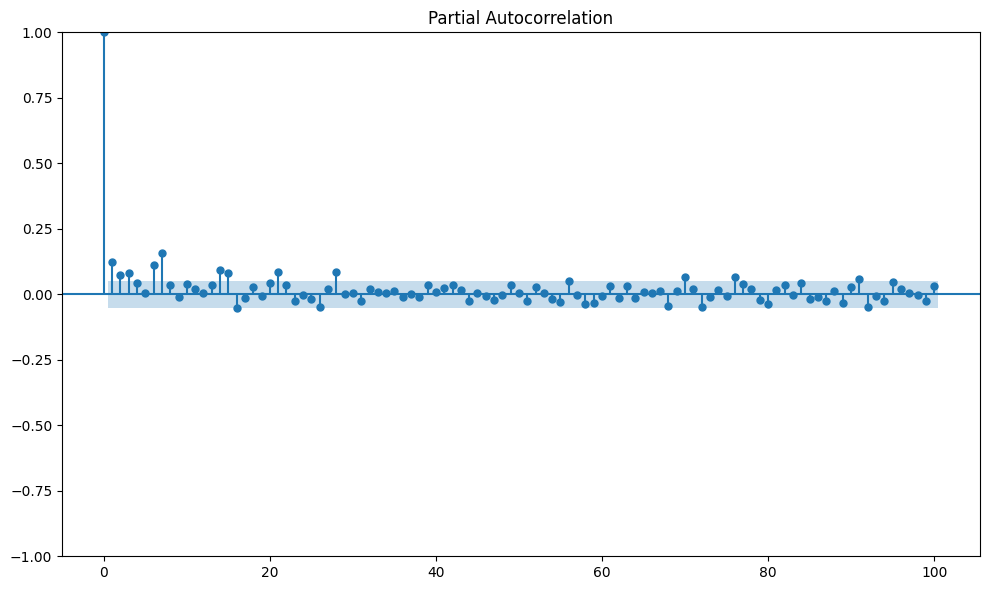

In [45]:
# ----------------------------
# 4) EDA (similar to your template)
# ----------------------------
plt.figure(figsize=(12,4))
plt.plot(daily_sales)
plt.title("Daily Sales — Superstore")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

month_plot(daily_sales.resample("ME").mean(), ylabel="Avg Sales")
plt.show()

quarter_plot(daily_sales.resample("QE").mean(), ylabel="Avg Sales")
plt.show()

# Decomposition: weekly seasonality (period=7) on daily data
decomp = seasonal_decompose(daily_sales, model="additive", period=7)
fig = decomp.plot()
fig.set_size_inches(16, 9)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
plot_acf(daily_sales, lags=100, ax=ax)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
plot_pacf(daily_sales, lags=100, ax=ax, method="ywm")
plt.tight_layout()
plt.show()

In [46]:
# ----------------------------
# 5) Amazon Chronos model
# ----------------------------
pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-base")

print(ChronosPipeline.predict.__doc__)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]


        Get forecasts for the given time series.

        Refer to the base method (``BaseChronosPipeline.predict``)
        for details on shared parameters.

        Additional parameters
        ---------------------
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        limit_prediction_length
            Force prediction length smaller or equal than the
            built-in prediction length from the model. False by
            default. When true, fail loudly if longer p

In [51]:
# ----------------------------
# 6) One-shot forecast (next N days)
# ----------------------------
prediction_length = 30  # next 30 days
context = torch.tensor(daily_sales.values, dtype=torch.float32)

forecast_samples = pipeline.predict(
    series=context,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
    prediction_length=prediction_length,
    num_samples=20,
    limit_prediction_length=False
)

# mean forecast across samples
forecast_mean = torch.mean(torch.stack([f[0] for f in forecast_samples]), dim=0).detach().cpu().numpy()

forecast_index = pd.date_range(
    start=daily_sales.index[-1] + pd.Timedelta(days=1),
    periods=prediction_length,
    freq="D"
)

forecast_series = pd.Series(forecast_mean, index=forecast_index, name="Chronos Forecast")
forecast_series.head()


# Plot last 200 days + forecast
plt.figure(figsize=(12,5))
plt.plot(daily_sales.tail(200), label="Actual (last 200d)")
plt.plot(forecast_series, label="Forecast")
plt.title("Amazon Chronos — Superstore Daily Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: ChronosPipeline.predict() got an unexpected keyword argument 'series'

In [49]:
# ----------------------------
# 7) Cross-validation (rolling origin)
# ----------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def time_series_cv_chronos(
    pipeline,
    series: pd.Series,
    horizon: int,
    stride: int,
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
    temperature: float = 1.0,
    top_k: int = 50,
    top_p: float = 1.0,
    num_samples: int = 20,
):
    results = []
    preds = []
    actuals = []

    current_date = start_date

    while current_date + pd.Timedelta(days=horizon) <= end_date:
        train = series[series.index < current_date]
        test = series[current_date : current_date + pd.Timedelta(days=horizon - 1)]

        if len(train) < 60:
            current_date += pd.Timedelta(days=stride)
            continue

        fc_samples = pipeline.predict(
            series=torch.tensor(train.values, dtype=torch.float32),
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            prediction_length=horizon,
            num_samples=num_samples,
            limit_prediction_length=False
        )

        fc_mean = torch.mean(torch.stack([f[0] for f in fc_samples]), dim=0).detach().cpu().numpy()

        e = rmse(test.values, fc_mean)
        results.append((current_date, e))
        preds.append(fc_mean)
        actuals.append(test.values)

        print(f"{current_date.date()} RMSE: {e:,.2f}")
        current_date += pd.Timedelta(days=stride)

    return pd.DataFrame(results, columns=["cutoff", "rmse"]), preds, actuals


# Example CV setup:
horizon = 30   # forecast 30 days ahead each split
stride = 14    # move cutoff forward by 14 days

# start_date: last (horizon*8) days back as a reasonable window
start_date = daily_sales.index[-horizon * 8]
end_date = daily_sales.index[-1]

cv_df, cv_preds, cv_actuals = time_series_cv_chronos(
    pipeline=pipeline,
    series=daily_sales,
    horizon=horizon,
    stride=stride,
    start_date=start_date,
    end_date=end_date,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
    num_samples=20
)

cv_df.head(), cv_df["rmse"].mean()


# Visualize a few CV splits
for i in range(min(3, len(cv_preds))):
    plt.figure(figsize=(10,4))
    plt.plot(cv_actuals[i], label="Actual")
    plt.plot(cv_preds[i], label="Predicted")
    plt.title(f"CV Split {i+1} — Horizon={horizon} days")
    plt.xlabel("Step")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

TypeError: ChronosPipeline.predict() got an unexpected keyword argument 'series'

# Task
Correct the `pipeline.predict` calls in cells `QFA1D7PtNIOm`, `6j8yOP-JNN0I`, and `iMkA_dBQNZJD` by removing the `series=` keyword, making the time series data the first positional argument. Then, execute these cells along with `809JOKPmNSho` to perform one-shot forecasting, cross-validation, parameter tuning, and a final tuned forecast.

## Correct ChronosPipeline.predict calls

### Subtask:
Modify the `pipeline.predict` calls in cells `QFA1D7PtNIOm`, `6j8yOP-JNN0I`, and `iMkA_dBQNZJD` to pass the time series data as the first positional argument, without the `series=` keyword.


**Reasoning**:
The user wants to fix a `TypeError` in the `pipeline.predict` calls by removing the `series=` keyword. I will update the `pipeline.predict` call in cell `QFA1D7PtNIOm` to pass the time series data as a positional argument.



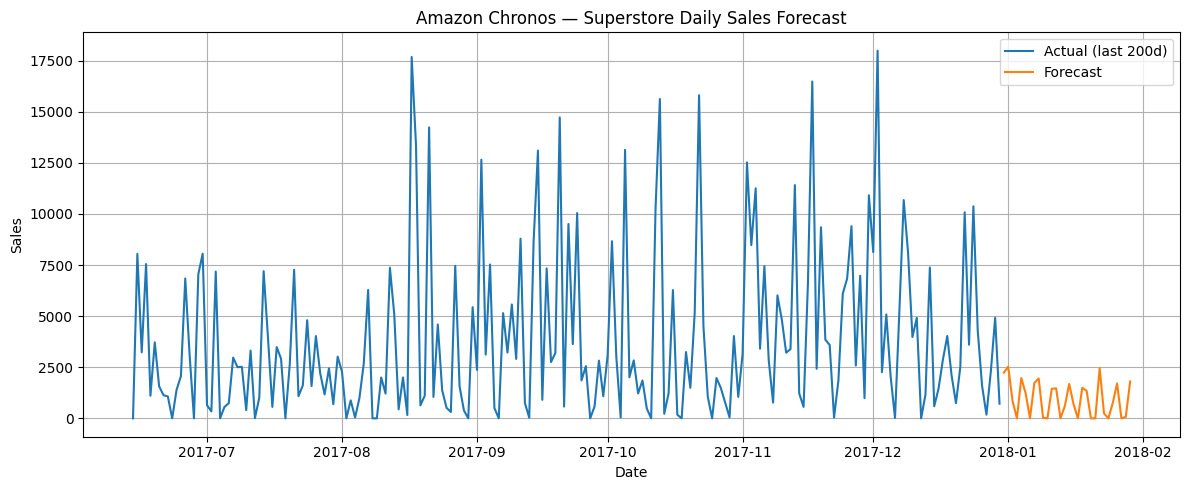

In [52]:
# ----------------------------
# 6) One-shot forecast (next N days)
# ----------------------------
prediction_length = 30  # next 30 days
context = torch.tensor(daily_sales.values, dtype=torch.float32)

forecast_samples = pipeline.predict(
    context,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
    prediction_length=prediction_length,
    num_samples=20,
    limit_prediction_length=False
)

# mean forecast across samples
forecast_mean = torch.mean(torch.stack([f[0] for f in forecast_samples]), dim=0).detach().cpu().numpy()

forecast_index = pd.date_range(
    start=daily_sales.index[-1] + pd.Timedelta(days=1),
    periods=prediction_length,
    freq="D"
)

forecast_series = pd.Series(forecast_mean, index=forecast_index, name="Chronos Forecast")
forecast_series.head()


# Plot last 200 days + forecast
plt.figure(figsize=(12,5))
plt.plot(daily_sales.tail(200), label="Actual (last 200d)")
plt.plot(forecast_series, label="Forecast")
plt.title("Amazon Chronos — Superstore Daily Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Reasoning**:
Continuing to fix the `TypeError`, I will modify the `pipeline.predict` call within the `time_series_cv_chronos` function in cell `6j8yOP-JNN0I` by removing the `series=` keyword.



2017-05-05 RMSE: 3,247.60
2017-05-19 RMSE: 3,486.99
2017-06-02 RMSE: 2,937.95
2017-06-16 RMSE: 3,083.12
2017-06-30 RMSE: 3,186.25
2017-07-14 RMSE: 3,075.62
2017-07-28 RMSE: 5,324.27
2017-08-11 RMSE: 5,492.97
2017-08-25 RMSE: 5,208.44
2017-09-08 RMSE: 5,225.59
2017-09-22 RMSE: 5,218.30
2017-10-06 RMSE: 5,447.56
2017-10-20 RMSE: 5,691.50
2017-11-03 RMSE: 6,478.45
2017-11-17 RMSE: 6,312.79


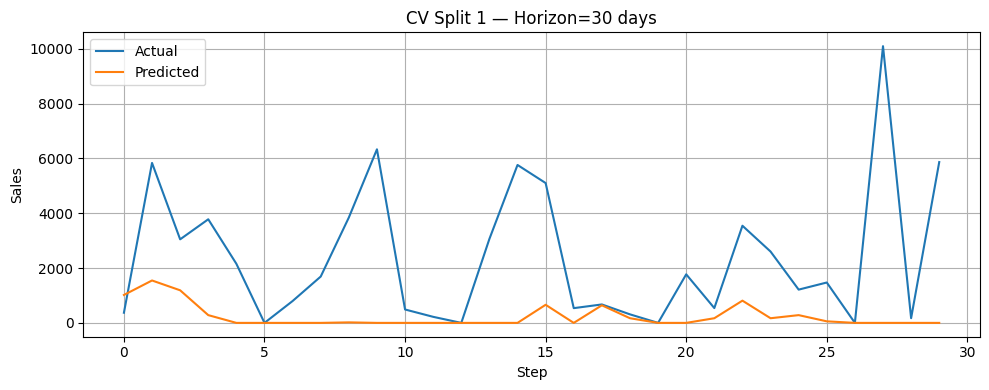

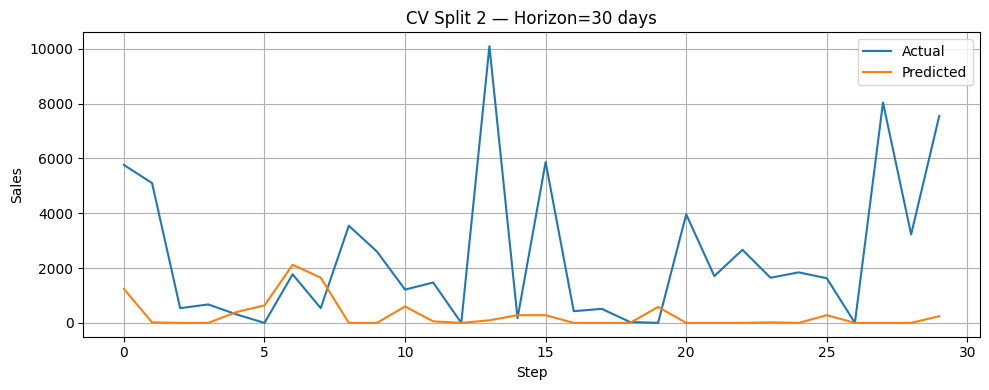

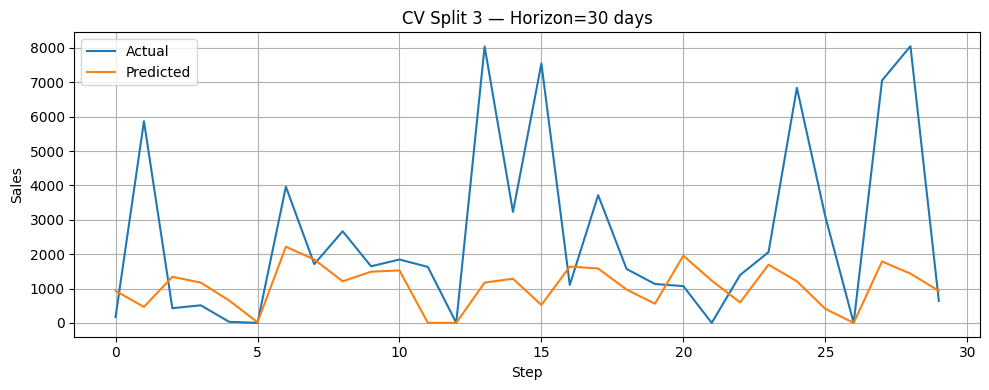

In [53]:
# ----------------------------
# 7) Cross-validation (rolling origin)
# ----------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def time_series_cv_chronos(
    pipeline,
    series: pd.Series,
    horizon: int,
    stride: int,
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
    temperature: float = 1.0,
    top_k: int = 50,
    top_p: float = 1.0,
    num_samples: int = 20,
):
    results = []
    preds = []
    actuals = []

    current_date = start_date

    while current_date + pd.Timedelta(days=horizon) <= end_date:
        train = series[series.index < current_date]
        test = series[current_date : current_date + pd.Timedelta(days=horizon - 1)]

        if len(train) < 60:
            current_date += pd.Timedelta(days=stride)
            continue

        fc_samples = pipeline.predict(
            torch.tensor(train.values, dtype=torch.float32),
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            prediction_length=horizon,
            num_samples=num_samples,
            limit_prediction_length=False
        )

        fc_mean = torch.mean(torch.stack([f[0] for f in fc_samples]), dim=0).detach().cpu().numpy()

        e = rmse(test.values, fc_mean)
        results.append((current_date, e))
        preds.append(fc_mean)
        actuals.append(test.values)

        print(f"{current_date.date()} RMSE: {e:,.2f}")
        current_date += pd.Timedelta(days=stride)

    return pd.DataFrame(results, columns=["cutoff", "rmse"]), preds, actuals


# Example CV setup:
horizon = 30   # forecast 30 days ahead each split
stride = 14    # move cutoff forward by 14 days

# start_date: last (horizon*8) days back as a reasonable window
start_date = daily_sales.index[-horizon * 8]
end_date = daily_sales.index[-1]

cv_df, cv_preds, cv_actuals = time_series_cv_chronos(
    pipeline=pipeline,
    series=daily_sales,
    horizon=horizon,
    stride=stride,
    start_date=start_date,
    end_date=end_date,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
    num_samples=20
)

cv_df.head(), cv_df["rmse"].mean()


# Visualize a few CV splits
for i in range(min(3, len(cv_preds))):
    plt.figure(figsize=(10,4))
    plt.plot(cv_actuals[i], label="Actual")
    plt.plot(cv_preds[i], label="Predicted")
    plt.title(f"CV Split {i+1} — Horizon={horizon} days")
    plt.xlabel("Step")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Reasoning**:
To complete the subtask, I need to modify the `pipeline.predict` call in cell `iMkA_dBQNZJD` by removing the `series=` keyword, making the time series data the first positional argument. This will fix the `TypeError` observed in the original execution attempt of this cell.



In [57]:
import os
import json

os.makedirs("models", exist_ok=True)

chronos_bundle = {
    "pipeline_id": "amazon/chronos-t5-base",
    "freq": "D",
    "default_horizon": 30,
    "params": {
        "temperature": 1.0,
        "top_k": 50,
        "top_p": 1.0,
        "num_samples": 20,
        "limit_prediction_length": False
    }
}

with open("models/chronos_superstore_config.json", "w") as f:
    json.dump(chronos_bundle, f, indent=2)

# optional but useful for Streamlit plots / context
daily_sales.to_csv("models/superstore_daily_sales_history.csv", header=True)

print("Saved: models/chronos_superstore_config.json")
print("Saved: models/superstore_daily_sales_history.csv")


Saved: models/chronos_superstore_config.json
Saved: models/superstore_daily_sales_history.csv
